# EEML'24: **Reinforcement Learning** Tutorial
---
**Authors**:
* Andreea Deac (adeac@isomorphiclabs.com)
* Ognjen Milinković (ognjen7amg@gmail.com)


## Motivation

This tutorial will explore policy-based reinforcement learning agents, starting from a random agent in a grid-like environment and finishing with fine-tuning a pre-trained language model in the style of RLHF.


## Outline

- Intro to policy-based RL
- Setup and installation of necessary Python libraries.
- Part I: Training a simple RL agent using REINFORCE.
- Part II: Building more complex agents: values, advantages, entropy -- A2C and PPO.
- Part III: Fine-tune GPT2 to give more positive reviews.

❗ Note: While a GPU is not mandatory for this tutorial, we recommend using it for Part 3 to speed up the training. You can do this by clicking `Runtime -> Change runtime type`, and set the hardware accelerator to GPU.

# Intro to policy-based Reinforcement Learning

## The RL problem

From the lecture earlier today, you probably already know that:
- RL is the problem of sequential decision making
- The learner is often not told what actions to take, but it needs to find out what to do (ie learn a policy) by trial-and-error
- The learning signal (ie the reward) might be delayed, meaning the agent needs to trade-off short and long-term consequences
- The agent needs to balance exploration and exploitation


This is formally summarised using the Markov Decision Process (MDP). The MDP defines the problem as (S, A, T, R): states S, actions A, transition function $T:S \times A \rightarrow S$ and reward function $R:S \times A \rightarrow \mathbb{R}$, with the aim of finding the solution in the form of a policy $\pi:S \rightarrow A$.

When the agent is a neural network, as is often the case in Deep Reinforcement Learning, we can think of the process of gathering data and learning from it as a cycle:
- in each state s, an action a is chosen with a certain probability (given by the policy).
- the agent can then perform the action a while being in state s
- this will lead to being in a new state $s'$ and obtaining a reward r, both provided by the environment.

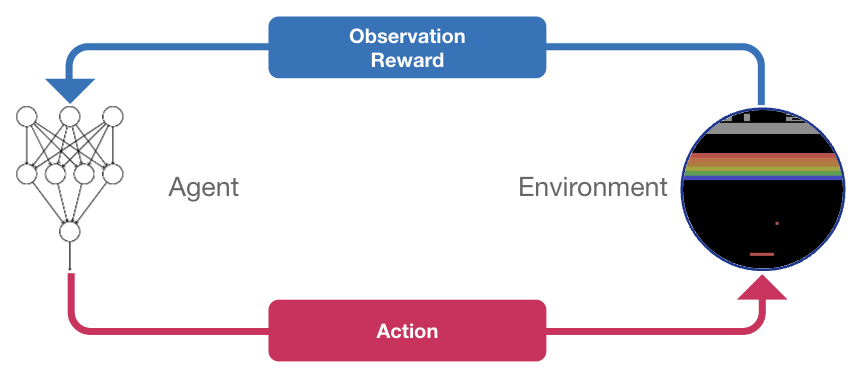



## Goal: maximise expected cumulative reward

As the agent takes actions (steps) in the environment, it builds its experience in the form of trajectories $$\tau=(s_0^\tau, a_0^\tau, r_0^\tau, s_1^\tau, a_1^\tau, r_1^\tau \dots, s_k^\tau, a_k^\tau, r_k^\tau, s_{k+1}^\tau)$$
where $s_0^\tau$ is the starting state and $s_{k+1}^\tau$ is either an intermmediate state or an ending state, determined either by achieving the goal, failing (e.g. doing a forbidden action), or reaching a timeout. A trajectory will form an/a part of an episode.

The aim is then to take actions that maximise the cumulative return:

$$R(\tau) = \sum_{t=0}^{k_\tau} \gamma^t r_t^\tau$$

where $\gamma$ is the discount factor that determines how much distant rewards contribute to the return compared to immediate ones.

Thus, for a policy $\pi$ the expected cumulative reward is:
$$ \mathbb{E}_{\pi}(\sum_{t=0}^{\infty} \gamma^t r_t) = \mathbb{E}_{\tau | \pi} (R(\tau)) = \sum R(\tau) \mathbb{P} (\tau | \pi)$$

## Maximising expected cumulative reward in policy-based RL

If we consider the policy $\pi$ to be parametrised by $\theta$, then we're looking to find
$$\theta' = argmax_{\theta} \ \mathbb{E}_{\pi_\theta}(\sum_{t=0}^{\infty} \gamma^t r_t) $$.

We will design the policy so that it is differentiable according to each of the parameters, which will allow us to calculate the gradient. Then we can train the parameters using gradient descent:

$$ \theta \leftarrow \theta + \eta \nabla_\theta \mathbb{E}_{\pi}(\sum_{t=0}^{\infty} \gamma^t r_t)$$

where $\eta$ is the learning rate.

We will see in Part I how this leads to REINFORCE, but first let's set up our own learning environment!

# Setup and library installation

## Environments


RL agents are trained by interacting with the environment and [gym](https://gymnasium.farama.org/index.html) is a standard suite that contains environments ranging from simple classic control, to Atari and multi-joint dynamics MuJoCo. For the purpose of the tutorial, we will be looking at Toy Text environments that have small, discrete state and action spaces such as FrozenLake
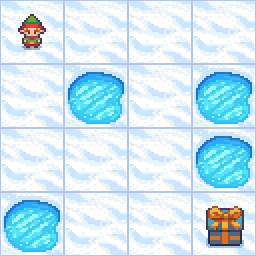

or environments with continuous state spaces such as CartPole

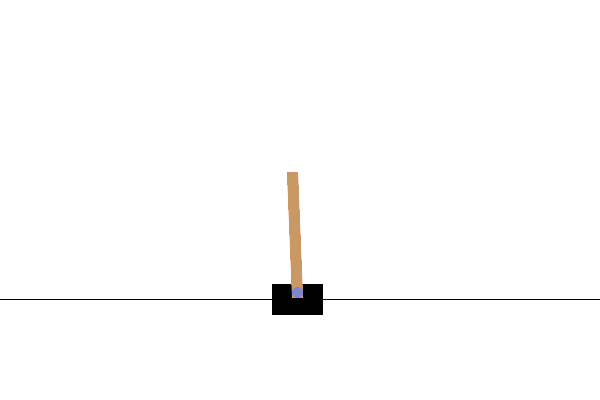


## Reinforcement Learning from Human Feedback
For the third part of the tutorial, we will make use of HuggingFace pre-trained models, through [trl](https://github.com/huggingface/trl) and [transformers](https://github.com/huggingface/transformers).

In [ ]:
%%capture
!python -m pip install gymnasium
!pip install datasets
!pip install trl
!pip install transformers[torch]
!pip install accelerate -U

In [ ]:
import glob
import io
import base64
from itertools import count

from tqdm import tqdm
import numpy as np
import pandas as pd
tqdm.pandas()

import gymnasium as gym  # standard suite of environments for RL
from gymnasium.wrappers.record_video import RecordVideo  # for visualising agents.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from IPython.display import HTML
from IPython import display as ipythondisplay

# Part I
We'll first define a class for a random policy. This policy will be a building block of an agent, that will act by sampling actions with probabilities given from a normal distribution.

You can similarly try sampling from a uniform distribution and observe how the agent's actions change!

In [ ]:
class Random_Policy(nn.Module):
  def __init__(self, env):
    super().__init__()
    self.env = env
    self.num_actions = self.env.action_space.n

  def forward(self, obs):
    ################################################################
    # Output a tensor of random probabilities for each possible action.
    # Your solution:
    ################################################################

  def parameters(self):
    return {torch.zeros(1,1)} # this is a dummy.

In some environments, the state and actions spaces are small. For example, in FrozenLake, pictured above, there are 16 states corresponding to each of the cells in the 4x4 grid, and 4 actions, corresponding to the up, down, left and right movements. Small environments such as this one can be solved using *tabular RL methods*, explicitly storing probabilities for each state-action pair, as shown in the class below.

In [ ]:
class Grid_Policy(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.policy = nn.Parameter(
            torch.zeros(env.observation_space.n, env.action_space.n)
        )

    def forward(self, obs):
        action_probs = F.softmax(self.policy[obs], dim=-1)
        return action_probs

    def __str__(self):
        match self.env.spec.id:
            case "FrozenLake-v1":
                action_map = ["<", "v", ">", "^"]
                map_shape = (4, 4)
            case "CliffWalking-v0":
                action_map = ["^", ">", "v", "<"]
                map_shape = (4, 12)
            case _:
                raise NotImplementedError


        policy_directions = self.policy.argmax(dim=-1).view(*map_shape)
        output = []

        for row in policy_directions:
            output.append("    ".join(action_map[x.item()] for x in row))

        return "\n".join(output)

## The REINFORCE algorithm

Now that we have two options that we can use for the policy class, let's build our agent. As mentioned in the intro, the agent uses the policy to sample actions that will be taken in the environment. From each step, the agent collects (possibly zero) rewards and the environment returns a new state. Based on the cumulative discounted rewards, the agent adapts its policy.

Below is REINFORCE, one fundamental algorithm for updating policy parameters. Analyse its steps, particularly its loss and cummulative reward, and use the pseudocode to complete a first agent!  


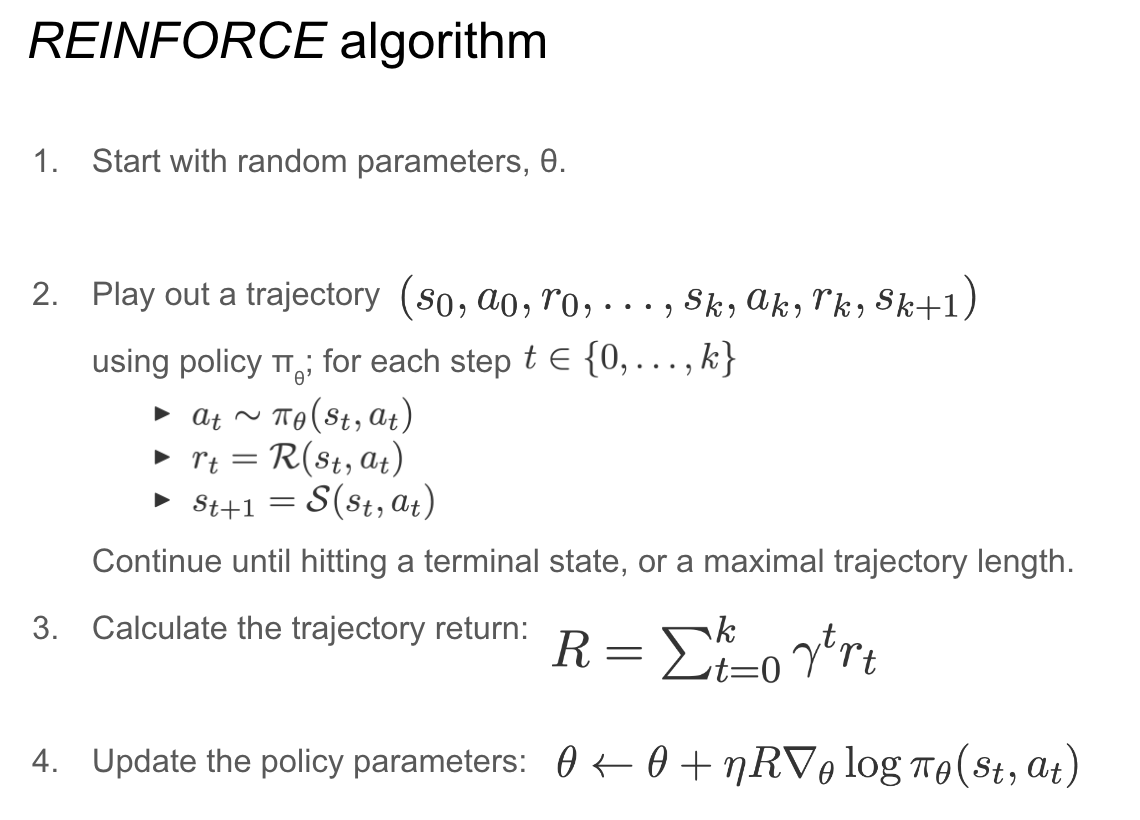

In [ ]:
class ReinforceAgent(nn.Module):
    def __init__(self, policy: nn.Module):
        super().__init__()
        self.policy = policy

        self.log_probs_history = []
        self.rewards_history = []
        self.terminated_history = []
        self.truncated_history = []

    def forward(self, obs):
        probs = self.policy(obs)
        distribution = Categorical(probs)
        action = distribution.sample()
        self.log_probs_history.append(distribution.log_prob(action))
        return action

    def update(self, optimizer):
        returns = self.discount_rewards(self.rewards_history,
                                        self.terminated_history,
                                        self.truncated_history)
        log_probs = torch.stack(self.log_probs_history)

        ################################################################
        # Implement the classic Reinforce loss.
        # Your solution:
        # loss = ...
        ################################################################

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        self.log_probs_history = []
        self.rewards_history = []
        self.terminated_history = []
        self.truncated_history = []

    def discount_rewards(self, rewards, terminated, truncated, gamma=0.99):
        ################################################################
        # Compute the returns using the given rewards and discount factor.
        # Your solution:
        ################################################################

Now that the agent is complete, let's use it! First, let's select the environment and our hyper-parameters.

In [ ]:
#@title Environment and agent selector.
environment = "CliffWalking-v0" # @param ["CliffWalking-v0", "FrozenLake-v1"]
render = False#@param {type:"boolean"}

env = gym.make(environment, render_mode="rgb_array")
recorder_env = RecordVideo(env, "./videos")

policy = "Grid" #@param ["Random", "Grid"]
agent = "Reinforce" #@param ["Reinforce"]

match agent:
    case "Reinforce":
        agent_cls = ReinforceAgent

match policy:
    case "Random":
        policy_cls = Random_Policy
    case "Grid":
        match agent:
            case "Reinforce":
                policy_cls = Grid_Policy

policy = policy_cls(env)
agent = agent_cls(policy)


lr = 0.1#@param
optimizer = optim.Adam(policy.parameters(), lr=lr)

match environment:
    case "CliffWalking-v0":
        max_reward = -15
    case "FrozenLake-v1":
        max_reward = -5
    case _:
        max_reward = float("inf")

episodes_per_batch = 5 # @param {type:"integer"}

max_episode_steps = 500 # @param {type:"integer"}

number_of_updates = 300 # @param {type:"integer"}

Fill-in the training loop to see how a random agent and a REINFORCE agent with a tabular policy act in FrozenLake. Feel free to play around with the learning rate or how many steps the agent can learn from, or move to a new environment altogether, such as CliffWalking!

In [ ]:
#@title Training loop.
for i in range(number_of_updates):
    rewards = []

    ################################################################
    # Implement the training loop.
    # Your solution:
    # for _ in range(episodes_per_batch):
        # Reset episodic reward.
        # Reset environment.
        # for _ in range(max_episode_steps):
            # Sample action.
            # Execute the action in the environment using env.step.
            # Check if done (episode terminated or out-of-time)
            # Update episodic reward, store rewards and done history.
            # if done:
                # break
        # rewards.append(ep_reward)
    ################################################################

    avg_reward = sum(rewards) / len(rewards)

    if i % 10 == 0:
        print("-------")
        print(f"{i}: Average reward: {avg_reward:.2f}")
        print("Policy:")
        print(agent.policy)
    if avg_reward == max_reward:
        print(f"{i}: Got max average reward")
        print("Policy:")
        print(agent.policy)
        break
    if not isinstance(agent.policy, Random_Policy):
      agent.update(optimizer)

Now that we have a prototype, let's improve our agents. Currently, the tabular policy will only work for small, discrete state-action spaces. When the state/action spaces get larger, we can use neural networks to parametrise the policy.

In [ ]:
class NN_Policy(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.obs_shape = env.observation_space.n if isinstance(env.observation_space, gym.spaces.Discrete) else env.observation_space.shape[0]
        self.obs_type = "Discrete" if isinstance(env.observation_space, gym.spaces.Discrete) else "Box"
        ################################################################
        # Build a simple policy using a 2-layer MLP.
        # Your solution:
        # self.policy = nn.Sequential(...)
        ################################################################

        self.log_probs_history = []
        self.rewards_history = []
        self.done_history = []

    def forward(self, obs):
        ################################################################
        # If the observation is discrete, transform it into a one-hot.
        # Your solution:
        # if self.obs_type == "Discrete":
          # obs = ...
        ################################################################

        obs = torch.tensor(obs)
        return self.policy(obs)

Now that you have a Reinforce neural-network based agent, train an agent using the training loop from above and visualise it using the code below.

In [ ]:
################################################################
# Train a NN-based Reinforce agent on CliffWalking.
# Your solution:
################################################################

In [ ]:
#@title Movie
def visualise_agent(recorder_env, agent, max_episode_steps):
  state, _ = recorder_env.reset()
  for _ in range(max_episode_steps):
      action = agent(state)
      state, _, terminated, truncated, _ = recorder_env.step(action.item())
      done = terminated or truncated
      if done:
          break

  mp4list = glob.glob('videos/*.mp4')
  if len(mp4list) > 0:
      mp4 = mp4list[0]
      video = io.open(mp4, 'r+b').read()
      encoded = base64.b64encode(video)
      ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))))

In [ ]:
visualise_agent(recorder_env, agent, max_episode_steps)

If all goes well, the agent should be collecting the cookie without falling off the cliff 🥳 Congratulations on your first successful RL agent!

We will next explore how to build more complex agents, for more complex environments.

# Part II

## Credit assignment

Intuitively, REINFORCE tries to assign higher credit to those action sequences that, altogether, led to a larger return (R).

However, we have no way of telling individual actions apart in this setting, or the relative meaning of actions from a single state:

- What if an action received a high reward, but there was a much better action from this state?
- What if an action received a high penalty, but no better action existed from this state?

Tackling such issues leads us to actor-critic algorithms, of which we will see [Advantage Actor-Critic(A2C)]() and [Proximal Policy Optimization (PPO)]().

## Values of states and actions

In order to progress, it is necessary to have an estimate of the value of some state, V(s), which can be defined as the expected value of the path in which the starting state $s_0 = s$.

Now, if we have a path, we can, for any step t, define the value of the action $a_t$ in the state $s_t$:

$$Q_t(s_t, a_t) = \sum_{i=0}^{k-t} \gamma^i r_{t+1} + \gamma^{k-t+i} V(s_{k+1})$$


## Modeling the advantages of actions

We can define the advantage of taking action $a_t$ in state $s_t$ as:
$$ A_t(s_t, a_t) = Q_t(s_t, a_t) - V(s_t)$$

By evaluating how much better-than-expected action $a_t$ is, advantages can then be used to scale each action in REINFORCE:

$$ \theta \leftarrow \theta + \eta A_t (s_t, a_t) \nabla_\theta \log \pi_\theta(s_t, a_t)$$

Therefore, this induces more balanced updates over states that have different reward scales.

In [ ]:
class Grid_Policy_Value(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.policy = nn.Parameter(
            torch.zeros(env.observation_space.n, env.action_space.n)
        )
        self.value = nn.Parameter(
            torch.zeros(env.observation_space.n)
        )

    def forward(self, obs):
        return F.softmax(self.policy[obs], dim=-1), self.value[obs]

    def __str__(self):
        match self.env.spec.id:
            case "FrozenLake-v1":
                action_map = ["<", "v", ">", "^"]
                map_shape = (4, 4)
            case "CliffWalking-v0":
                action_map = ["^", ">", "v", "<"]
                map_shape = (4, 12)
            case _:
                raise NotImplementedError


        policy_directions = self.policy.argmax(dim=-1).view(*map_shape)
        output = []

        for row in policy_directions:
            output.append("    ".join(action_map[x.item()] for x in row))

        return "\n".join(output)

In [ ]:
################################################################
# The previous cell shows a grid agent that uses both a policy and a value predictor.
# Based on this principle and the NN_Policy, implement an A2C agent
# that learns a hidden state representation of the observation from which
# a policy and a value are predicted.
# Your solution:
# class NN_Policy_Value(nn.Module):
    # def __init__(self, env):
        # self.obs_shape = env.observation_space.n if isinstance(env.observation_space, gym.spaces.Discrete) else env.observation_space.shape[0]
        # self.obs_type = "Discrete" if isinstance(env.observation_space, gym.spaces.Discrete) else "Box"
        # self.hidden = nn.Sequential(...)
        # self.policy_head = nn.Sequential(...)
        # self.value_head = nn.Sequential(...)

    # def forward(self, obs):
        # if self.obs_type == "Discrete":
            # ...
        # ...
        # return probs, value
################################################################

## The Advantage Actor Critic algorithm
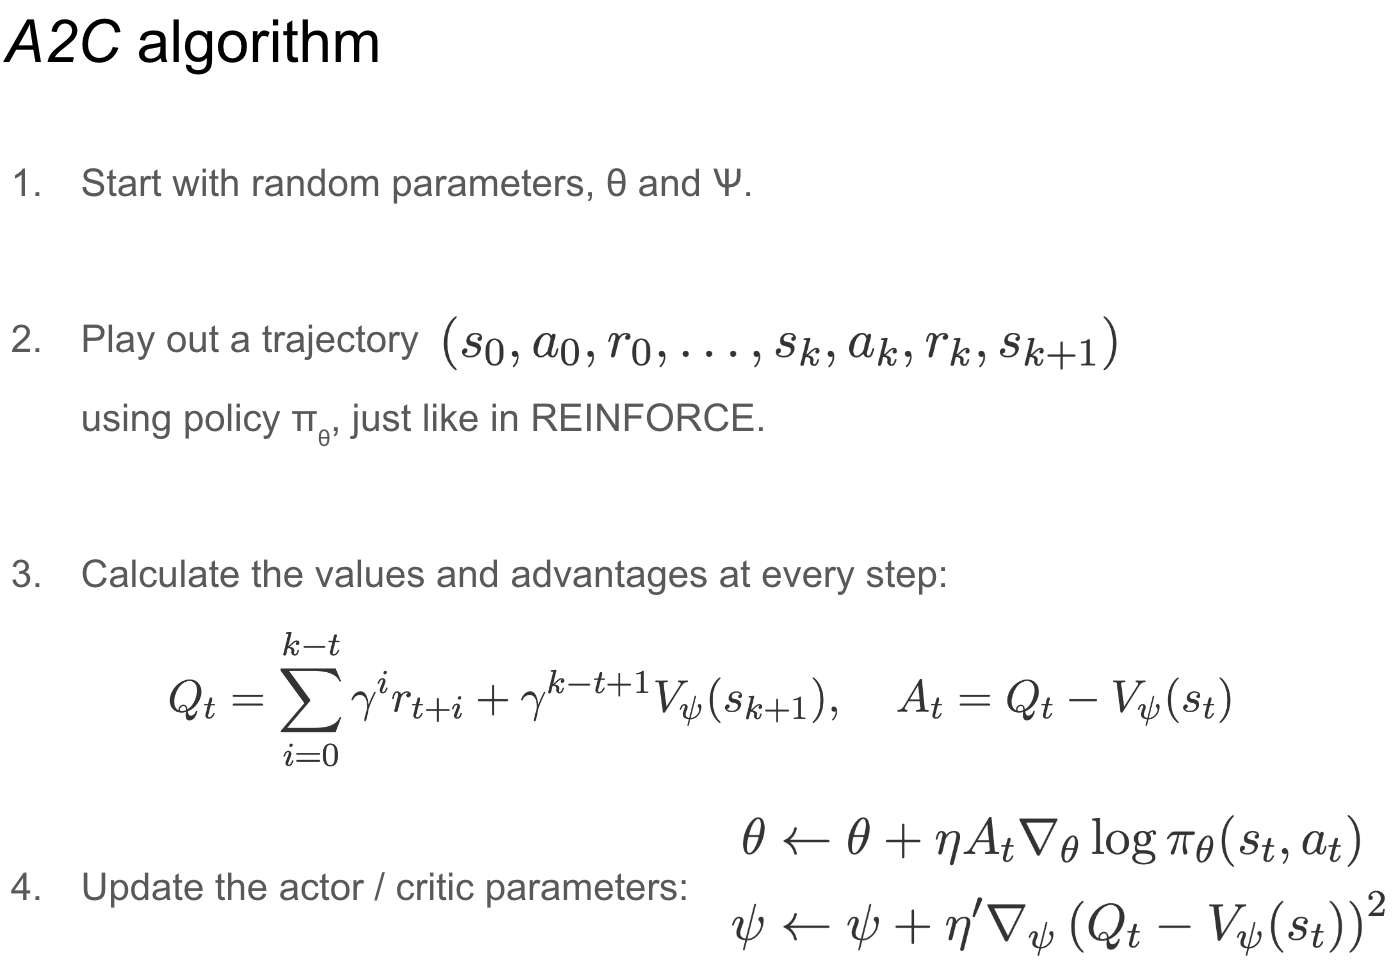

In [ ]:
class A2CAgent(nn.Module):
    def __init__(self, policy):
        super().__init__()

        self.value_coefficient = 0.01
        self.policy = policy

        self.log_probs_history = []
        self.actions_history = []
        self.rewards_history = []
        self.values_history = []
        self.terminated_history = []
        self.truncated_history = []
        self.truncated_state_values = []

    def forward(self, obs):
        probs, value = self.policy(obs)
        distribution = Categorical(probs)
        action = distribution.sample()
        self.log_probs_history.append(distribution.log_prob(action))
        self.actions_history.append(action)
        self.values_history.append(value)

        return action

    def update(self, optimizer):
        returns = self.discount_rewards(self.rewards_history,
                                        self.terminated_history,
                                        self.truncated_history,
                                        self.truncated_state_values,)

        log_probs = torch.stack(self.log_probs_history)
        values = torch.stack(self.values_history).squeeze()

        ################################################################
        # Compute the A2C loss.
        # Your solution:
        # advantage = ...
        # policy_loss = ...
        # value_loss = ...
        # loss = policy_loss + self.value_coefficient * value_loss
        ################################################################

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        self.log_probs_history = []
        self.actions_history = []
        self.rewards_history = []
        self.values_history = []
        self.terminated_history = []
        self.truncated_history = []
        self.truncated_state_values = []

    def discount_rewards(self, rewards, terminated, truncated, truncated_state_values, gamma=0.99):
        ################################################################
        # Compute the returns using the given rewards and discount factor.
        # Your solution:
        ################################################################

Run your NN-based A2C agent on "CartPole-v1", similarly to how you used NN-Reinforce for the CliffWalking environment.

In [ ]:
################################################################
# Train and visualise a NN-based A2C agent on CartPole.
# Your solution:
################################################################

# Moving to state-of-the-art agent PPO

## Exploration or exploitation

A big problem to pay attention to in reinforcement learning is the problem of exploration versus exploitation.

We don't want to become overconfident about our policy right away—it's probably not optimal in the early stages of training, when we need to encourage the agent to explore!

We want to favor more "chaotic" policies at the beginning.
One measure by which we can determine "chaos" in a probability distribution is its entropy.

If we have a random variable X that takes one of k values, with probabilities p1, ..., pk, then its entropy, H(X), is defined as:

$$ H(X) = - \sum_{i=1}^k p_i \log p_i $$


Entropy roughly defines how much "information" we learn when we learn the value of X.
Outcomes with higher probabilities are less informative (because we expect them).

- Entropy is highest (system is most chaotic) when, for all i, pi ≈ 1/k (uniform distribution).
- Entropy is the smallest (the system is the most stable) when, for some i, pi ≈ 1, and otherwise pj ≈ 0.

### Entropy regularization

In practice, we will add a parameter to the update of the policy parameters $\pi_\theta$ that will maintain the entropy in the policy to some extent.

Specifically, we now update the parameters as follows:

$$ \theta \leftarrow \theta + \eta(A_t \nabla_\theta \log \pi_\theta(s_t, a_t) + \beta \nabla_\theta H(\pi_\theta(s_t))) $$

The parameter β controls how chaotic a policy we want: one suitable option is to start with high values (so as not to prematurely converge to a suboptimal policy), and gradually reduce them during training.


Try changing the A2C implementation to include entropy regularization term.

In [ ]:
class A2CEntropyAgent(nn.Module):
    def __init__(self, policy):
        super().__init__()

        self.value_coefficient = 0.01
        self.entropy_coefficient = 0.01
        self.policy = policy

        self.log_probs_history = []
        self.actions_history = []
        self.rewards_history = []
        self.values_history = []
        self.terminated_history = []
        self.truncated_history = []
        self.truncated_state_values = []
        self.state_history = []

    def forward(self, obs):
        obs = torch.tensor(obs)
        probs, value = self.policy(obs)
        distribution = Categorical(probs)
        action = distribution.sample()
        self.log_probs_history.append(distribution.log_prob(action))
        self.actions_history.append(action)
        self.values_history.append(value)
        self.state_history.append(obs)  # can be used to compute entropy.
        return action

    def update(self, optimizer):
        returns = self.discount_rewards(self.rewards_history,
                                        self.terminated_history,
                                        self.truncated_history,
                                        self.truncated_state_values,)

        log_probs = torch.stack(self.log_probs_history)
        values = torch.stack(self.values_history).squeeze()
        states = torch.stack(self.state_history).squeeze().detach()
        probs, state_values = self.policy(states)

        ################################################################
        # Implement the A2C with Entropy loss.
        # Your solution:
        # ...
        # advantage = ...
        # policy_loss = ...
        # value_loss = ...
        # loss = policy_loss + self.value_coefficient * value_loss - \
          # self.entropy_coefficient * entropy
        ################################################################

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        self.log_probs_history = []
        self.actions_history = []
        self.rewards_history = []
        self.values_history = []
        self.terminated_history = []
        self.truncated_history = []
        self.truncated_state_values = []

    def discount_rewards(self, rewards, terminated, truncated, truncated_state_values, gamma=0.99):
        ################################################################
        # Compute the returns using the given rewards and discount factor.
        # Your solution:
        ################################################################

## Training stability

When directly optimising the policy's parameters, it was noted that small differences in parameter space can lead to very large differences in performance, meaning that one bad update can collapse the performance. In fact, you might notice this if you train A2C on MountainCar or CartPole repeatedly -- some seeds will get unlucky and have a significant drop in performance from which it can take a lot of samples to recover.

To improve sample efficiency and training stability, algorithms such as Trust Region Policy Optimization (TRPO) and Proximal Policy Optimization (PPO) were proposed, that add a special condition on how far a new policy can be from the previous iterations of the policies.

## The PPO loss

In practice, the PPO algorithm introduces two new changes that can be combined with the A2C with entropy agent you just implemented.

Firstly, it uses clipping in the objective function to keep the new policy close to the old policy $\theta_k$:

$$ L(s, a, \theta_k, \theta) = min ( \texttt{ratio} A^{\pi_{\theta_k}}(s,a), \texttt{clip}(ratio, 1-\epsilon, 1+\epsilon)A^{\pi_{\theta_k}}(s,a))$$


where $\texttt{ratio}=\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}$.

Secondly, for sample efficiency and faster convergence, PPO performs multiple gradient updates on a batch of data by having an inner loop in the update function.

In [ ]:
class PPOAgent(nn.Module):
    def __init__(self, policy):
        super().__init__()

        self.policy = policy

        self.n_inner_epochs = 4
        self.clamp_margin = 0.2

        self.log_probs_history = []
        self.actions_history = []
        self.rewards_history = []
        self.values_history = []
        self.terminated_history = []
        self.truncated_history = []
        self.truncated_state_values = []
        self.state_history = []


    def forward(self, obs):
        obs = torch.tensor(obs)
        probs, value = self.policy(obs)
        distribution = Categorical(probs)
        action = distribution.sample()

        self.state_history.append(obs)
        self.log_probs_history.append(distribution.log_prob(action))
        self.actions_history.append(action)
        self.values_history.append(value)

        return action

    def update(self, optimizer):
        old_log_probs = torch.stack(self.log_probs_history).squeeze().detach()
        old_values = torch.stack(self.values_history).squeeze().detach()
        old_actions = torch.stack(self.actions_history).squeeze().detach()
        old_states = torch.stack(self.state_history).squeeze().detach()

        returns = self.discount_rewards(self.rewards_history,
                                        self.terminated_history,
                                        self.truncated_history,
                                        self.truncated_state_values,)
        returns = returns.squeeze().detach()
        advantages = returns - old_values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)

        dataset = torch.utils.data.TensorDataset(
                old_states,
                old_actions,
                old_log_probs,
                returns,
                advantages
            )
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

        from copy import deepcopy
        old_policy = deepcopy(self.policy)
        for _ in range(self.n_inner_epochs):
            for old_states, old_actions, old_log_probs, returns, advantages in dataloader:
                old_states = old_states.squeeze()
                old_actions = old_actions.squeeze()
                old_log_probs = old_log_probs.squeeze()
                returns = returns.squeeze()
                advantages = advantages.squeeze()

                ################################################################
                # Implement the PPO loss.
                # Your solution:

                # policy_loss = ...
                # value_loss = ..
                # loss = policy_loss + 0.5 * value_loss - 0.01 * entropy
                ################################################################

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
                optimizer.step()

        self.log_probs_history = []
        self.actions_history = []
        self.rewards_history = []
        self.values_history = []
        self.terminated_history = []
        self.truncated_history = []
        self.truncated_state_values = []
        self.state_history = []

    def discount_rewards(self, rewards, terminated, truncated, truncated_state_values, gamma=0.99):
        discounted_rewards = torch.zeros(len(rewards))
        running_add = 0
        for t in reversed(range(len(rewards))):
            if terminated[t]:
                running_add = 0
            elif truncated[t]:
                running_add = truncated_state_values.pop()
            running_add = running_add * gamma + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards.detach()

Now use the agents you build, comparing them on one of the previous environments or try a new one such as MountainCar-v0, while varying parameters such as learning rate, number of episodes per batch or number of maximum steps per episode.

In [ ]:
################################################################
# Train and visualise agents on your environment of choice.
# Your solution:
################################################################

In [ ]:
#@title Environment and agent selector.
environment = "FrozenLake-v1" # @param ["CartPole-v1", "MountainCar-v0", "CliffWalking-v0", "FrozenLake-v1"]
render = False#@param {type:"boolean"}

env = gym.make(environment, render_mode="rgb_array")
recorder_env = RecordVideo(env, "./videos")

policy = "Grid" #@param ["Random", "Grid", "NN"]
agent = "A2C" #@param ["Reinforce", "A2C", "A2CEntropy", "PPO"]

match agent:
    case "Reinforce":
        agent_cls = ReinforceAgent
    case "A2C":
        agent_cls = A2CAgent
    case "A2CEntropy":
        agent_cls = A2CEntropy
    case "PPO":
        agent_cls = PPOAgent

match policy:
    case "Random":
        policy_cls = Random_Policy
    case "Grid":
        assert isinstance(env.observation_space, gym.spaces.Discrete),\
                "If you want to use grid policy pick descrete environment."
        match agent:
            case "Reinforce":
                policy_cls = Grid_Policy
            case "A2C":
                policy_cls = Grid_Policy_Value
            case "A2CEntropy":
              policy_cls = Grid_Policy_Value
            case "PPO":
                policy_cls = Grid_Policy_Value
    case "NN":
        match agent:
            case "Reinforce":
                policy_cls = NN_Policy
            case "A2C":
                policy_cls = NN_Policy_Value
            case "A2CEntropy":
                policy_cls = NN_Policy_Value
            case "PPO":
                policy_cls = NN_Policy_Value

policy = policy_cls(env)
agent = agent_cls(policy)


lr = 0.1#@param
optimizer = optim.Adam(policy.parameters(), lr=lr)

match environment:
    case "CartPole-v1":
        max_reward = 500
    case "CliffWalking-v0":
        max_reward = -15
    case "FrozenLake-v1":
        max_reward = 1
    case _:
        max_reward = float("inf")

episodes_per_batch = 5 # @param {type:"integer"}

max_episode_steps = 500 # @param {type:"integer"}

number_of_updates = 1000 # @param {type:"integer"}

In [ ]:
#@title Training loop.

# Extend the previous training loop,
# taking into consideration the extra state some algorithms need, such as
# agent.truncated_state_values for A2C/PPO.

In [ ]:
visualise_agent(recorder_env, agent, max_episode_steps)

You've now build some advanced RL agents! In fact, PPO is still a state-of-the-art algorithm for language model post-training, as in the case of Reinforcement Learning from Human Feedback (RLHF).

We will next see this in action!

# Part III

## Fine-tuning large language models

In the last few years, large language models (LLMs) have become very powerful and, consequently, very popular. They are known to learn general language knowledge, due to the training objective and the large amounts of data used.

In case we want to use an LLM for a specialised task, a highly recommended solution is to fine-tune it -- this allows the use of a small dataset, while still maintaining the benefits of broad language understanding.

## GPT2 for positive reviews

For the last part of the tutorial, we'll fine-tune a pre-trained GPT2 to give positive continuations.

To do this, we'll think of GPT2 as our policy and we'll use a BERT classifier as a reward function. BERT was pre-trained on the sentiment analysis task (predicting whether the text is either positive or negative).

**N.B.** This section is based on [Tune GPT2 to generate positive reviews](https://huggingface.co/docs/trl/v0.1.1/en/sentiment_tuning).

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, pipeline
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe_device = 0 if torch.cuda.is_available() else -1

Next, we'll set the hyper-parameters:
-  `config` for fine-tuning the pretrained LLM model using PPO
- `sent_kwargs` for the reward (sentiment analysis) model
- `gen_kwargs` for generating data with the LLM, which can be considered as gathering the trajectories by sampling actions from the agent's policy.

In [ ]:
pretrained_llm = "lvwerra/gpt2-imdb" #@param ["lvwerra/gpt2-imdb"]

config = {
    "model_name": pretrained_llm,
    "cls_model_name": "lvwerra/distilbert-imdb",
    "steps": 20000,
    "batch_size": 256,
    "forward_batch_size": 16,
    "ppo_epochs": 4,
    "txt_in_min_len": 2,
    "txt_in_max_len": 8,
    "txt_out_min_len": 4,
    "txt_out_max_len": 16,
    "lr": 1.41e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1,
}

sent_kwargs = {
    "return_all_scores": True,
    "function_to_apply": "none",
    "batch_size": config["forward_batch_size"]
}

gen_kwargs = {
    "min_length":-1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": None, # We will add this after creating tokenizer
}

Next, we'll load the IMDB dataset. We'll use the samples as prompts for GPT2 to generate continuations for. In a way, we can think of the prompts as states based on which the actions (responses) are selected.

In [ ]:
ds = load_dataset('imdb', split='train')
ds = ds.rename_columns({'text': 'review', 'label': 'sentiment'})
ds = ds.filter(lambda x: len(x["review"])>200, batched=False)
ds

In [ ]:
sentiment_pipe = pipeline("sentiment-analysis","lvwerra/distilbert-imdb", device=pipe_device)

text = 'this movie was really bad!!'
sentiment_pipe(text, **sent_kwargs)

text = 'this movie was really good!!'
sentiment_pipe(text, **sent_kwargs)

We'll create two models GPT2 model instances, one that will be fine-tuned and one that won't so that we can compare their responses for the same prompts.

In [ ]:
gpt2_model = AutoModelForCausalLMWithValueHead.from_pretrained(config['model_name'])
gpt2_model_ref = AutoModelForCausalLMWithValueHead.from_pretrained(config['model_name'])

gpt2_tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gen_kwargs["pad_token_id"] = gpt2_tokenizer.eos_token_id

gpt2_model.to(device);
gpt2_model_ref.to(device);

For more varied behaviours, we use the LengthSampler to randomise the length of the queries and the responses. We also pre-tokenise the samples in the dataset.

In [ ]:
class LengthSampler:
    def __init__(self, min_value, max_value):
        self.values = list(range(min_value, max_value))
    def __call__(self):
        return np.random.choice(self.values)

input_size = LengthSampler(config["txt_in_min_len"], config["txt_in_max_len"])
output_size = LengthSampler(config["txt_out_min_len"], config["txt_out_max_len"])

In [ ]:
def tokenize(sample):
    sample["tokens"] = gpt2_tokenizer.encode(sample["review"])[:input_size()]
    sample["query"] = gpt2_tokenizer.decode(sample["tokens"])
    return sample

ds = ds.map(tokenize, batched=False)

In [ ]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

dataloader = torch.utils.data.DataLoader(ds, batch_size=config['batch_size'], collate_fn=collator)

In [ ]:
ppo_config = PPOConfig(batch_size=256, mini_batch_size=16)
ppo_trainer = PPOTrainer(ppo_config, gpt2_model, gpt2_model_ref, gpt2_tokenizer) # , **config)

## Training loop

Fine-tuning GPT2 to give more positive reviews can be done in three steps:

- Get query responses from the policy network (GPT2)
- Get rewards for responses from BERT
- Optimise policy with PPO

In [ ]:
total_ppo_epochs = int(np.ceil(config["steps"]/config['batch_size']))

for epoch, batch in tqdm(zip(range(total_ppo_epochs), iter(dataloader))):
    ################################################################
    # Fine-tune GPT2 using the pre-trained distilbert-imdb as the reward function.
    # Your solution:
    # Get the query tensors using batch["tokens"].
    # query_tensors = ...

    # Get response from gpt2
    # response_tensors = []
    # for i in range(config['batch_size']):
        # Use gpt2_model.generate() to get the responses.
        # response = ...
        # response_tensors.append(...)
    # batch['response'] = [gpt2_tokenizer.decode(r.squeeze()) for r in response_tensors]

    # Compute sentiment score, concatenating batch['query'] and batch['response']
    # to build the input for sentiment_pipe.
    # ...
    # rewards = ...

    # Run PPO step.
    #stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    ################################################################

    #### Log everything
    table_rows = [list(r) for r in zip(batch['query'], batch['response'], rewards.cpu().tolist())]
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()

    # Only 3 fine-tuning epochs should give a noticeable difference,
    # but feel free to run for longer.
    if epoch == 2:
        break

We can now compare the reference model `gpt2_ref` (marked as *before*) with the fine-tuned model `gpt2` (marked as *after*) by sampling responses from both of them, and analysing them qualitatively and quantitatively using the reward.

In [ ]:
#### get a batch from the dataset
bs = 16
game_data = dict()
ds.set_format("pandas")
df_batch = ds[:].sample(bs)
game_data['query'] = df_batch['query'].tolist()
query_tensors = df_batch['tokens'].tolist()

response_tensors_ref, response_tensors = [], []

#### get response from gpt2 and gpt2_ref
for i in range(bs):
    gen_len = output_size()
    output = gpt2_model_ref.generate(torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
                                     max_new_tokens=gen_len, **gen_kwargs).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    output = gpt2_model.generate(torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
                                 max_new_tokens=gen_len, **gen_kwargs).squeeze()[-gen_len:]
    response_tensors.append(output)

#### decode responses
game_data['response (before)'] = [gpt2_tokenizer.decode(response_tensors_ref[i]) for i in range(bs)]
game_data['response (after)'] = [gpt2_tokenizer.decode(response_tensors[i]) for i in range(bs)]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q,r in zip(game_data['query'], game_data['response (before)'])]
game_data['rewards (before)'] = [output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)]

texts = [q + r for q,r in zip(game_data['query'], game_data['response (after)'])]
game_data['rewards (after)'] = [output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)]

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

In [ ]:
print('mean:')
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print('median:')
display(df_results[["rewards (before)", "rewards (after)"]].median())

You should be able to see noticeable differences even after fine-tuning a relatively old LLM for only two epochs 😀 Feel free to experiment with different reward functions or different LLMs!

This concludes our RL tutorial! Hope you enjoyed it and we're looking forward to seeing how you build on this knowledge!